In [1]:
import numpy as np
import math
from scipy.optimize import *
import pandas as pd
from matplotlib import pyplot as plt
from lmfit import Model

In [2]:
data = "Feb_12_20_01.csv"
df = pd.read_csv(data)
df.columns = ['XValue', 'Time', 'Laser_Power', 'Shutter', 'Ch_A', 'Ch_B', 'DE_exp', 'stage_angle']
df = df.iloc[1:,]
df.drop(df.columns[[0,1,2,3,4,5]], axis = 1, inplace = True)
df.head()

,DE_exp,stage_angle
1,0.010416,-14.548
2,0.010502,-14.448
3,0.010502,-14.408
4,0.010570,-14.368
5,0.010591,-14.328


In [3]:
n = len(df.stage_angle) #number of angles considered
Bragg_angle_ext = np.deg2rad(18) #Bragg angle for red beam, it is 12 for blue beam #EXTERNAL BRAGG
Bragg_angle_int = np.arcsin((1/1.5)*(np.sin(Bragg_angle_ext)))
df.stage_angle = np.deg2rad(df.stage_angle) #convert angles to radians to make them suitable for trigonometry functions
df["ext_angle"] = Bragg_angle_ext + df.stage_angle
df["int_angle"] = np.arcsin((1/1.5)*(np.sin(df.ext_angle))) #Snell's law for the external angle, to change to internal angles

df['Delta_theta_ext'] = (df.ext_angle - Bragg_angle_ext) #get the deviation from bragg angle
df['Delta_theta_int'] = (df.int_angle - Bragg_angle_int)

Period = 1e-6
n_nut = 1.5
Lambda = 633e-9
phi = 90
Delta_Lambda = 0
K = (2*math.pi)/Period
Beta = (2*math.pi*(n_nut))/Lambda

In [4]:
x = df.int_angle
y = df.DE_exp - 0.01

#----- Define the function with parameters
def func(x, Delta_n, L):
    nu = ((math.pi*Delta_n*L)/(Lambda)*((((np.cos(Bragg_angle_int)**2))-((K*np.cos(phi)*np.cos(Bragg_angle_int))/Beta))**0.5))
    xi = (((df.Delta_theta_int*K*np.sin(phi-Bragg_angle_int)-((Delta_Lambda*K**2)/(4*np.pi*n_nut)))*L)/2*((np.cos(df.int_angle))-(K*np.cos(phi))/Beta))
    df["xi"] = xi
    return ((np.sin(((nu**2)+(df.xi**2))**0.5)**2)/(1+(df.xi**2)/(nu**2)))


In [5]:
init_vals = [3e-3, 21e-6]  # for [Delta_n,cen, L]
best_vals, covar = curve_fit(func, x, y, p0=init_vals)
print('best_vals: {}'.format(best_vals))

best_vals: [3.23488476e-03 2.40181355e-05]


In [6]:
gmodel = Model(func)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

parameter names: ['Delta_n', 'L']
independent variables: ['x']


In [7]:
params = gmodel.make_params(Delta_n=3e-3, L=21e-6)

In [8]:
result = gmodel.fit(y, x=x, Delta_n=3e-3, L=21e-6)

In [9]:
print(result.fit_report())

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 323
    # variables        = 2
    chi-square         = 0.00372253
    reduced chi-square = 1.1597e-05
    Akaike info crit   = -3668.83452
    Bayesian info crit = -3661.27921
[[Variables]]
    Delta_n:  0.00323488 +/- 1.9135e-05 (0.59%) (init = 0.003)
    L:        2.4018e-05 +/- 1.6094e-07 (0.67%) (init = 2.1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Delta_n, L) = -0.948


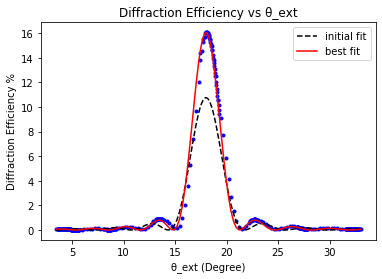

In [10]:
df.int_angle = np.rad2deg(df.int_angle)
df.ext_angle = np.rad2deg(df.ext_angle)
plt.plot(df.ext_angle, y*100, 'b.')
plt.plot(df.ext_angle, result.init_fit*100, 'k--', label='initial fit')
plt.plot(df.ext_angle, result.best_fit*100, 'r-', label='best fit')
plt.title("Diffraction Efficiency vs θ_ext")
plt.xlabel("θ_ext (Degree)")
plt.ylabel("Diffraction Efficiency %")
plt.legend(loc='best')
plt.show()

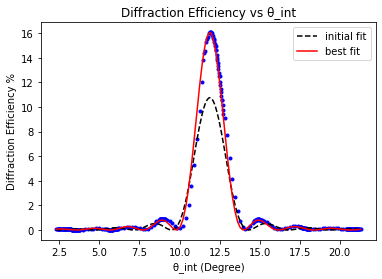

In [11]:
plt.plot(df.int_angle, y*100, 'b.')
plt.plot(df.int_angle, result.init_fit*100, 'k--', label='initial fit')
plt.plot(df.int_angle, result.best_fit*100, 'r-', label='best fit')
plt.title("Diffraction Efficiency vs θ_int")
plt.xlabel("θ_int (Degree)")
plt.ylabel("Diffraction Efficiency %")
plt.legend(loc='best')
plt.show()

In [12]:
dn = best_vals[0]
d = best_vals[1]

def onbragg(Lambda,Period,n_nut,phi,Delta_Lambda,dn,d):
    K = (2*math.pi)/Period
    Beta = (2*math.pi*(n_nut))/Lambda
    nu = ((math.pi*dn*d)/(Lambda)*((((np.cos(Bragg_angle_int)**2))-((K*np.cos(phi)*np.cos(Bragg_angle_int))/Beta))**0.5))
    DE_Kb = (np.sin(nu)**2)
    print ("The Modulation Parameter on bragg is: ", nu)
    print("Diffraction Efficiency at Bragg Condition is: ", DE_Kb*100, "%")
    return DE_Kb
    
    
onbragg(633e-9, 1e-6, 1.5, 90, 0, dn, d)

The Modulation Parameter on bragg is:  0.41420957065907743
Diffraction Efficiency at Bragg Condition is:  16.197925924780847 %


0.16197925924780845